## Import

In [1]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
%config InlineBackend.figure_format = 'retina' # For high-resolution.
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch 
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam


import cv2
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

import segmentation_models_pytorch as smp


## Hyperparameters

In [3]:
## Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.cuda.device_count())

RESOLUTION = 256
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = True

LEARNING_RATE = 1e-4
NUM_EPOCHS = 20



cuda
1


## Create Data Frames

In [4]:
def read_df(df_type):
    df_path = '/home/mel011/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format(df_type)
    df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path']]
    df['Mask_Path'] = df['Mask_Path'].str.replace('anw008', 'mel011')
    df['XRay_Path'] = df['XRay_Path'].str.replace('anw008', 'mel011')
    
    return df

In [5]:
train_df = read_df('train')
val_df = read_df('validation')
test_df = read_df('test')

## Creat Datasets & Dataloaders

In [6]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution):
        self.img_paths = df['XRay_Path'].values
        self.mask_paths = df['Mask_Path'].values
        
        self.resolution = resolution
          
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = dicom.dcmread(img_path).pixel_array
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = (img - img_min) / (img_max - img_min)
        img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
        img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)
        
        mask_path = self.mask_paths[idx]
        mask = plt.imread(mask_path)[:, :, 0]
        mask = cv2.resize(mask, (self.resolution, self.resolution))
        mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 
        
        return img_norm, mask

In [7]:
train_ds = CANDID_PTX(train_df, RESOLUTION)
val_ds = CANDID_PTX(val_df, RESOLUTION)
# test_ds = CANDID_PTX(test_df, 1024)

In [8]:
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

# test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
#                           pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)


## Train UNET

In [9]:
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

In [10]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
def training(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader):
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
    all_preds = []
    all_masks = []
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        model.train()
        
        for i, (imgs, masks) in enumerate(train_loader):
            batch_num += 1
            
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            
            optimizer.zero_grad()
            preds = model(imgs)
            if i == 0:
                all_preds.append(preds.detach().cpu())
                all_masks.append(masks.detach().cpu())
            
            if (i == 0) & (epoch == 0):
                print(preds)
#             print(preds.size())
#             print(masks.size())

            
            loss = loss_fn(preds, masks)
    
            loss.backward()
            optimizer.step()
            
            
#             with torch.cuda.amp.autocast():
#                 preds = model(imgs)
#                 if i == 0:
#                     all_preds.append(preds.detach().cpu())
#                 loss = loss_fn(preds, masks)
                        
#             optimizer.zero_grad()
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
            
            total_train_loss += float(loss)
            
            
        if epoch == 0:
            print("Total # of training batch: ", i + 1)

        all_train_loss.append(total_train_loss / batch_num)
            
            
    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()
        
        for i, (imgs, masks) in enumerate(val_loader):
            batch_num += 1
            
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            
            preds = model(imgs)
            
            loss = loss_fn(preds, masks) # is this mean or sum?

            total_val_loss += float(loss) # accumulate the total loss for this epoch.

        if epoch == 0:
            print("Total # of validation batch: ", i + 1)

        all_val_loss.append(total_val_loss / batch_num)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss, all_preds, all_masks

In [12]:
torch.cuda.empty_cache()
unet_model, train_loss, val_loss, logit_mask, true_mask = training(model = model,
                                            num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = train_loader, val_loader = val_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([[[[ 0.2937,  0.2885,  0.9638,  ...,  0.2670,  0.4954,  0.6556],
          [ 0.4723,  0.5025,  1.6320,  ...,  0.3621,  0.7877, -0.0991],
          [ 0.8689,  0.3238,  1.4380,  ...,  0.3608,  0.9790,  0.4454],
          ...,
          [ 0.9877,  0.2135,  0.2781,  ...,  0.4327,  1.3338,  0.5120],
          [ 1.0421,  0.4495,  1.0644,  ...,  1.0431,  1.4555,  0.6810],
          [ 0.5572,  0.5009,  1.0681,  ...,  0.3219,  1.0739,  0.2804]]],


        [[[ 0.0327,  0.0349,  0.7135,  ...,  0.1316,  0.2018,  0.4469],
          [ 0.1637,  0.1768,  0.7546,  ...,  0.1818,  0.7158, -0.0694],
          [ 0.4876, -0.0581,  0.9725,  ...,  0.3060,  0.4139,  0.7314],
          ...,
          [ 0.4685,  0.1277,  0.3380,  ...,  0.9736,  1.6991,  0.9146],
          [ 0.6102,  0.1600,  0.3575,  ...,  1.0101,  1.8869,  0.9730],
          [ 0.4026,  0.4570,  0.5865,  ...,  0.5992,  1.3076,  0.5332]]],


        [[[ 0.1326,  0.1451,  0.7557,  ...,  0.1895,  0.2487,  0.2342],
          [ 0.2393,  0.325

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of validation batch:  480


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [13]:
def plot_both_loss(all_train_loss, all_val_loss, model_name, resolution):
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    epoch_num = len(all_train_loss)
    df = pd.DataFrame({'x':range(epoch_num),
                    'train_loss':all_train_loss,
                      'val_loss':all_val_loss})
    df = df.set_index('x')
    
    train_val_loss = sns.lineplot(data=df, linewidth=2.5)

    ## now label the y- and x-axes.
    plt.ylabel('Customize MAE Loss')
    plt.xlabel('Epoch Number')
    plt.title('BCE Loss of {} with resolution {}'.format(model_name, resolution))
    plt.show()
    
    fig = train_val_loss.get_figure()
    #fig.save('train_val_loss.png')

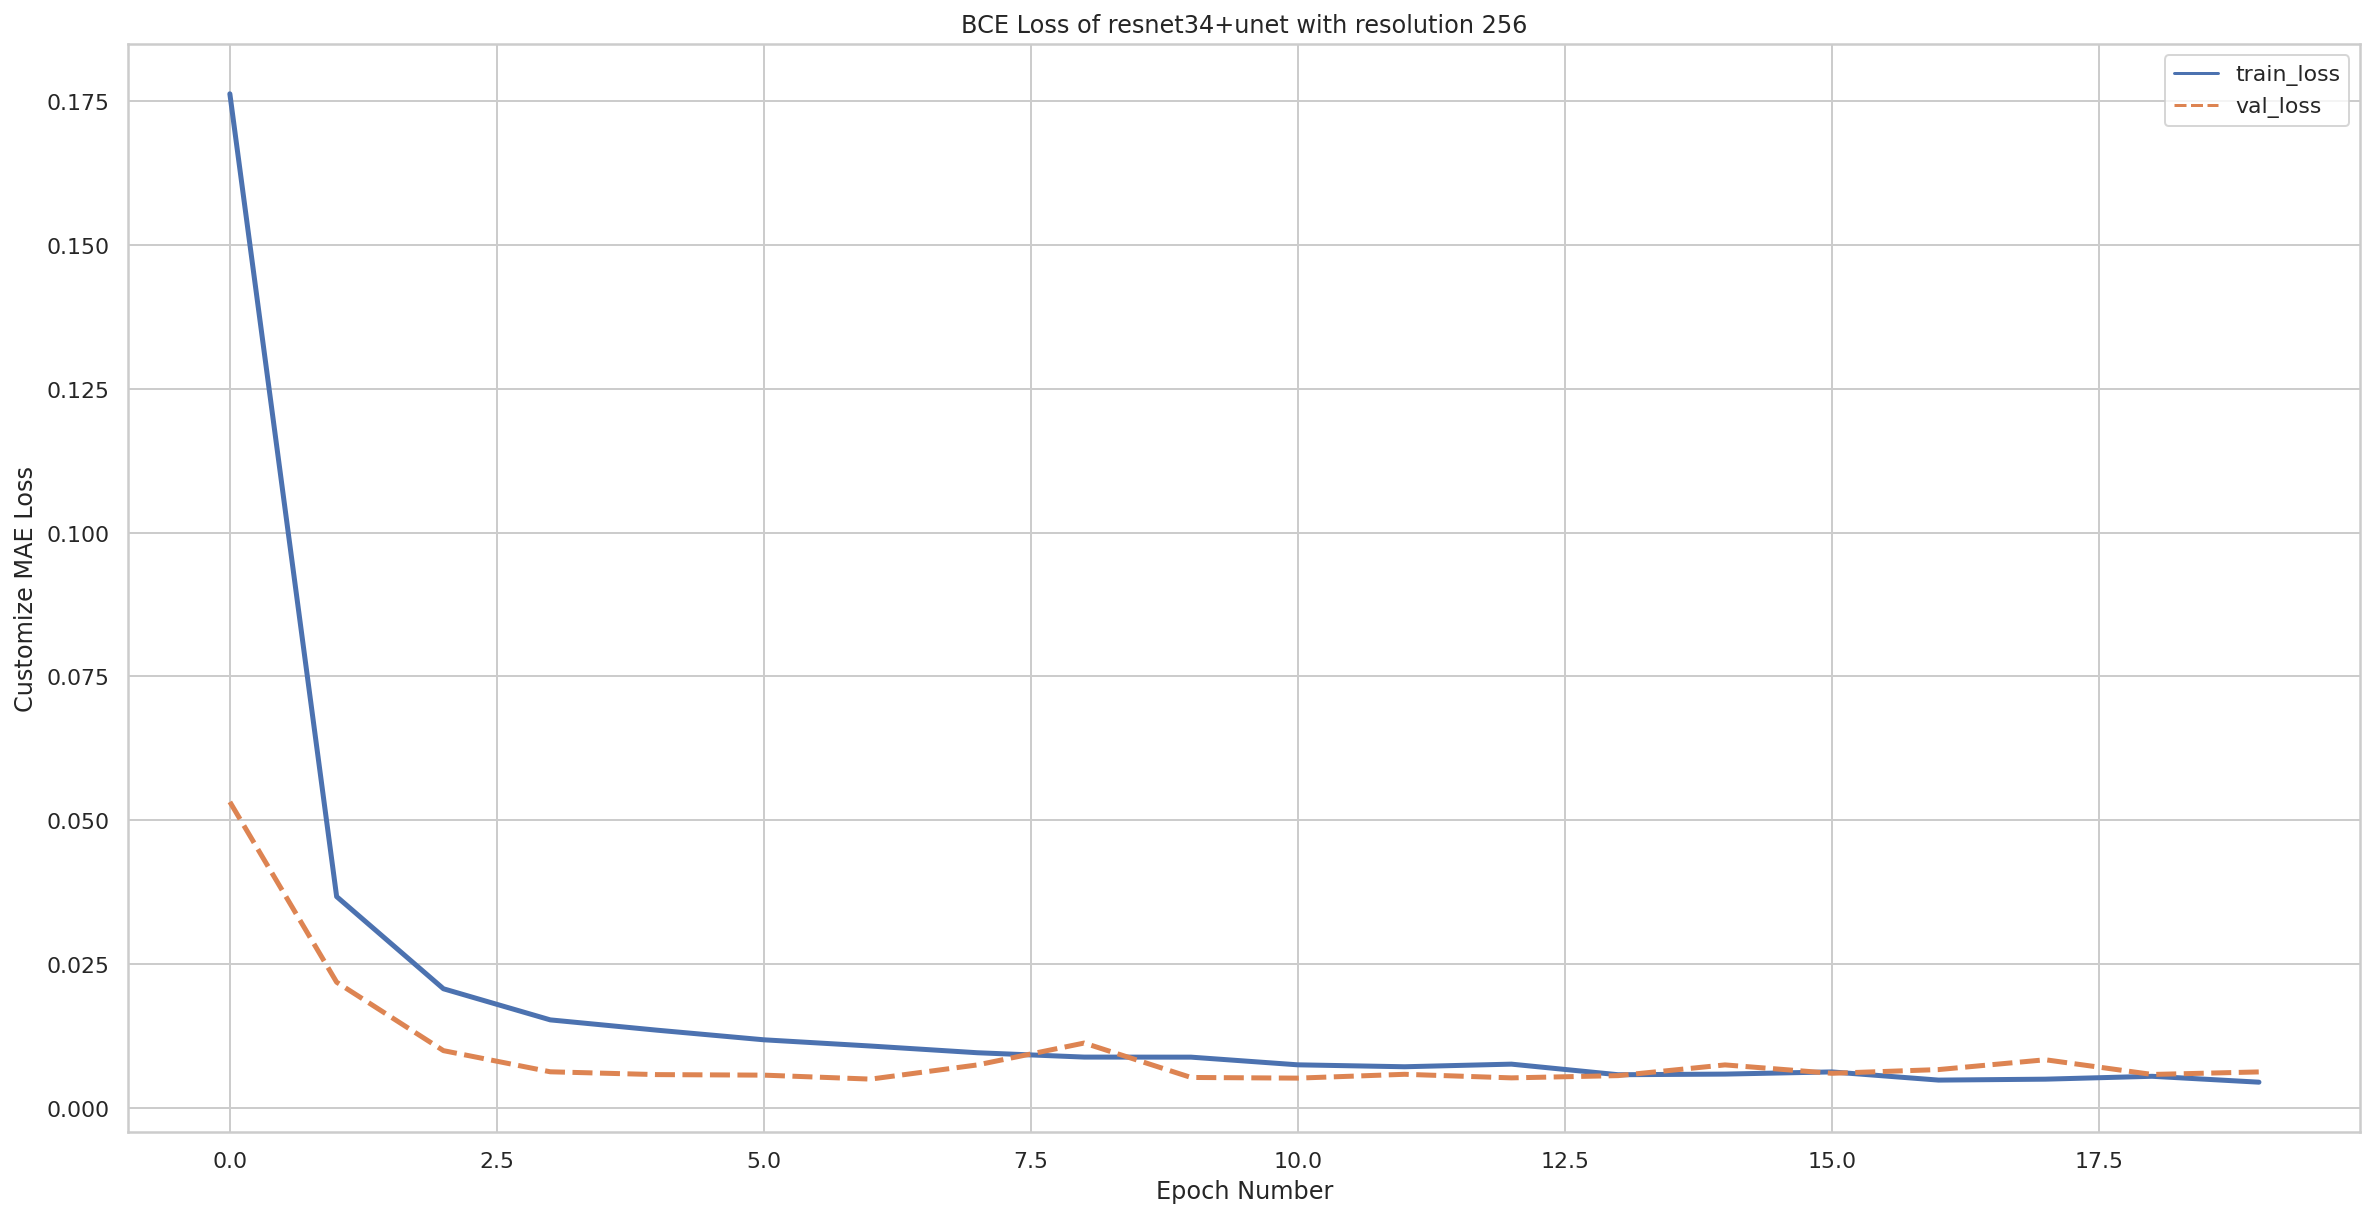

In [14]:
plot_both_loss(train_loss, val_loss, 'resnet34+unet', str(RESOLUTION))

In [15]:
def bi_mask(logit_mask, threshold):
    mask = np.where(logit_mask <= threshold, 0, 1)
    
    return mask

In [16]:
pred_1 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][0].squeeze())
pred_2 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][1].squeeze())
pred_3 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][2].squeeze())
pred_4 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][3].squeeze())

In [17]:
pred_1_bi = bi_mask(pred_1, 0.5)
pred_2_bi = bi_mask(pred_2, 0.5)
pred_3_bi = bi_mask(pred_3, 0.5)
pred_4_bi = bi_mask(pred_4, 0.5)

In [18]:
true_1 = true_mask[NUM_EPOCHS - 1][0].squeeze()
true_2 = true_mask[NUM_EPOCHS - 1][1].squeeze()
true_3 = true_mask[NUM_EPOCHS - 1][2].squeeze()
true_4 = true_mask[NUM_EPOCHS - 1][3].squeeze()


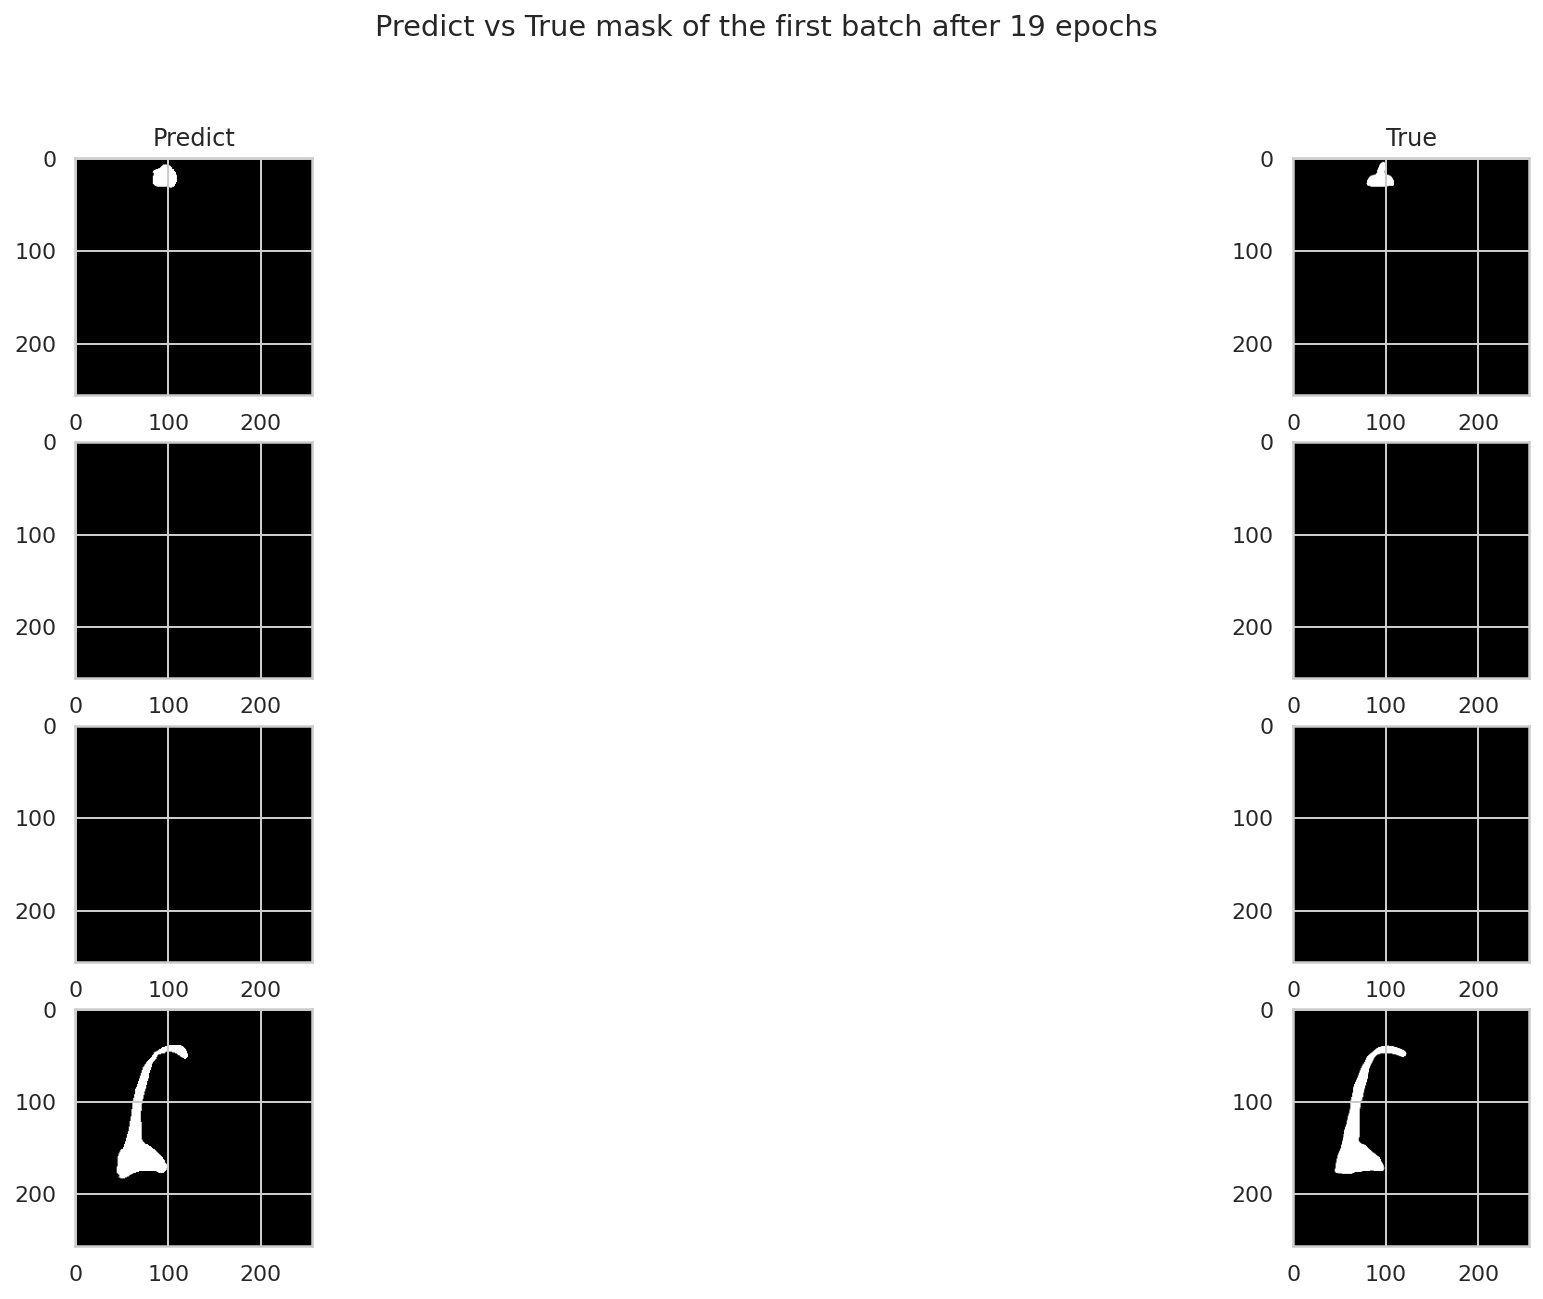

In [19]:
fig_size = (20, 10)
fig, axs = plt.subplots(4, 2, figsize = fig_size)
axs[0][0].imshow(pred_1_bi, cmap='gray')
axs[0][0].title.set_text('Predict')
axs[0][1].imshow(true_1, cmap='gray')
axs[0][1].title.set_text('True')
#plt.show()
axs[1][0].imshow(pred_2_bi, cmap='gray')
axs[1][1].imshow(true_2, cmap='gray')

#plt.show()
axs[2][0].imshow(pred_3_bi, cmap='gray')
axs[2][1].imshow(true_3, cmap='gray')

axs[3][0].imshow(pred_4_bi, cmap='gray')
axs[3][1].imshow(true_4, cmap='gray')

fig.suptitle('Predict vs True mask of the first batch after {} epochs'.format(str(NUM_EPOCHS - 1)))
plt.show()
